<div style="background-color:#1e1e1e; color:#f0f0f0; padding:12px; border-radius:8px; line-height:1.5; font-size:16px;">

<h2 style="margin-top:0; color:#ffffff;">Options</h2>

The goal of this notebook is to explore several options strategies. To do so, we use both 
<span style="color:#7CFC00;"><b>yahoo finance (yfinance)</b></span> and 
<span style="color:#00CED1;"><b>polygon.io</b></span> data.<br><br>

We lean mostly on the polygon data, which means that each user of this notebook will have to create and store a 
<span style="color:#00CED1;"><b>polygon API key</b></span> somewhere on their local machine.<br><br>

<b style="color:#FF6F61;">Note:</b> The polygon API key that I 
<span style="color:#DA70D6;"><b>(Mike Kovacevich)</b></span> have used to gather the data below corresponds to one of Polygon's paid tiers 
(I think it is $30 a month or something). The goal was to get access to options contracts and be able to analyze them via the "Greeks" and Implied Volatility

</div>


In [1]:
#Install any necessary packages here rather than the command line
!uv pip install dotenv
!uv pip install polygon-api-client

Using Python 3.12.9 environment at: /Users/michaelkovacevich/projects/ad-hoc/.venv
Audited 1 package in 28ms
Using Python 3.12.9 environment at: /Users/michaelkovacevich/projects/ad-hoc/.venv
Audited 1 package in 10ms


In [2]:
import os
import requests
from dotenv import load_dotenv
from datetime import datetime, timedelta
from datetime import timezone as dt_timezone

#Retrieve the API key from another directory that is NOT uploaded to Github
load_dotenv()
API_KEY = os.getenv("POLYGON_API_KEY")

Below we create functions that load options contracts for a given stock ticker (e.g AAPL, AAL, etc). We look at a specific date range of contracts since we want to analyze mediumish term contracts

In [ ]:
def analyze_option_contract(underlying: str, option_ticker: str, api_key: str):
    """Fetch and display Greeks and IV for a specific option contract."""
    url = f"https://api.polygon.io/v3/snapshot/options/{underlying}/{option_ticker}?apiKey={api_key}"
    response = requests.get(url)

    if response.status_code != 200:
        raise ValueError(f"Error fetching option detail: HTTP {response.status_code}")

    data = response.json()
    results = data.get("results", {})

    greeks = results.get("greeks", {})
    delta = greeks.get("delta")
    gamma = greeks.get("gamma")
    theta = greeks.get("theta")
    vega = greeks.get("vega")

    implied_volatility = results.get("implied_volatility")

    print("\nOption Details:")
    print(f"Delta: {delta}")
    print(f"Gamma: {gamma}")
    print(f"Theta: {theta}")
    print(f"Vega: {vega}")
    print(f"Implied Volatility: {implied_volatility}")

    return results

def get_current_stock_price(ticker: str) -> float:
    """Fetch current stock price from Polygon."""
    url = f"https://api.polygon.io/v2/last/trade/{ticker}?apiKey={API_KEY}"
    resp = requests.get(url)
    resp.raise_for_status()
    return resp.json()["last"]["price"]

def get_option_contracts(ticker: str, limit: int = 1000, min_days: int = 20, max_days: int = 180):
    """Fetch option contracts for a given ticker within a specified expiration range."""
    base_url = "https://api.polygon.io/v3/reference/options/contracts"
    params = {
        "underlying_ticker": ticker,
        "limit": limit,
        "apiKey": API_KEY
    }

    today = datetime.now(dt_timezone.utc).date()
    min_exp = today + timedelta(days=min_days)
    max_exp = today + timedelta(days=max_days)

    contracts = []
    url = base_url

    while url:
        response = requests.get(url, params=params)
        data = response.json()

        if not data.get("results"):
            break

        for c in data["results"]:
            exp_date = datetime.strptime(c["expiration_date"], "%Y-%m-%d").date()
            if min_exp <= exp_date <= max_exp:
                greeks_data = analyze_option_contract(ticker, c["ticker"], API_KEY)
                if greeks_data:
                    c["greeks"] = greeks_data  # Optional: store greeks
                    contracts.append(c)

        url = data.get("next_url")
        params = {}  # Only needed for the first request

    return contracts

def print_options_contracts(contracts):
    if not contracts:
        print("No option contracts to display.")
        return

    print(f"{'Index':<6} {'Ticker':<25} {'Strike':<10} {'Type':<6} {'Style':<10} {'Expires':<12} {'Exchange'}")
    print("-" * 100)
    for idx, c in enumerate(contracts):
        print(f"{idx:<6} {c['ticker']:<25} {c['strike_price']:<10} {c['contract_type']:<6} {c['exercise_style']:<10} {c['expiration_date']:<12} {c['primary_exchange']}")


In [6]:
#The code below is more script like rather than a notebook - should be cleaned up
if __name__ == "__main__":
    ticker = "NVDA"
    contracts = get_option_contracts(ticker)

    if contracts:
        print_options_contracts(contracts)
        try:
            index = int(input("\nEnter the index of the contract to analyze: "))
            selected = contracts[index]
            print(f"Selected ticker is: {selected['ticker']}")
            print("\nAnalyzing contract:")
            analyze_option_contract(ticker, selected["ticker"], API_KEY)
        except (ValueError, IndexError):
            print("Invalid selection. Exiting.")
    else:
        print("No contracts found in the specified range.")


HTTPError: 403 Client Error: Forbidden for url: https://api.polygon.io/v2/last/trade/NVDA?apiKey=VNNPAfiFpErEg8jI_HhitL_fpteEvdcE

In [8]:
#Lets look at an options contract below, just to observe the schema
contracts[180]

{'cfi': 'OPASPS',
 'contract_type': 'put',
 'exercise_style': 'american',
 'expiration_date': '2025-08-29',
 'primary_exchange': 'BATO',
 'shares_per_contract': 100,
 'strike_price': 95,
 'ticker': 'O:NVDA250829P00095000',
 'underlying_ticker': 'NVDA',
 'greeks': {'day': {'change': 0,
   'change_percent': 0,
   'close': 0.05,
   'high': 0.05,
   'last_updated': 1753732800000000000,
   'low': 0.04,
   'open': 0.04,
   'previous_close': 0.05,
   'volume': 4,
   'vwap': 0.0475},
  'details': {'contract_type': 'put',
   'exercise_style': 'american',
   'expiration_date': '2025-08-29',
   'shares_per_contract': 100,
   'strike_price': 95,
   'ticker': 'O:NVDA250829P00095000'},
  'greeks': {'delta': -0.002332782197736077,
   'gamma': 0.00015836349492040407,
   'theta': -0.00554408180968453,
   'vega': 0.0028711591805406366},
  'implied_volatility': 0.8756619015485028,
  'open_interest': 101,
  'underlying_asset': {'ticker': 'NVDA'}}}

KeyError: 't'

In [ ]:
# Define inputs manually like in a script
strike_price = 170.0      # Example: NVDA strike price
call_premium = 9.20       # Premium paid for the long call
put_premium = 6.25        # Premium paid for the long put

# --- Core Calculations ---
def long_call_breakeven(strike, premium):
    return strike + premium

def long_put_breakeven(strike, premium):
    return strike - premium

def long_straddle_breakeven(strike, call, put):
    total_premium = call + put
    return strike - total_premium, strike + total_premium

# --- Perform Calculations ---
call_be = long_call_breakeven(strike_price, call_premium)
put_be = long_put_breakeven(strike_price, put_premium)
straddle_be_low, straddle_be_high = long_straddle_breakeven(strike_price, call_premium, put_premium)

# --- Output ---
print(f"Break-even for Long Call (strike {strike_price}): ${call_be:.2f}")
print(f"Break-even for Long Put  (strike {strike_price}): ${put_be:.2f}")
print(f"Break-even range for Long Straddle: ${straddle_be_low:.2f} to ${straddle_be_high:.2f}")


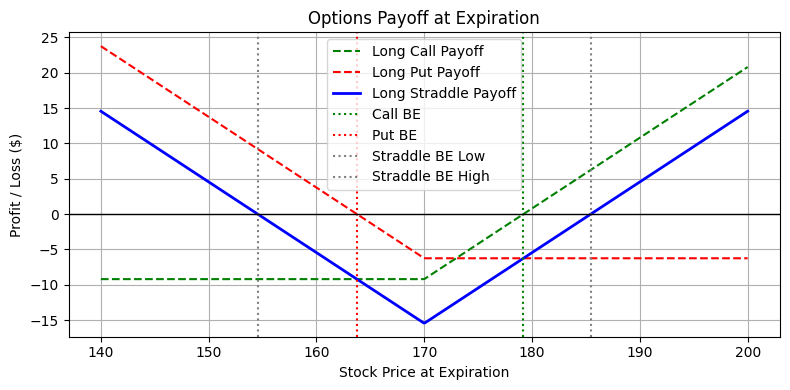

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# --- Inputs ---
strike_price = 170
call_premium = 9.20
put_premium = 6.25
stock_prices = np.linspace(140, 200, 500)  # Simulate NVDA price range

call_payoff = np.maximum(stock_prices - strike_price, 0) - call_premium
put_payoff = np.maximum(strike_price - stock_prices, 0) - put_premium
straddle_payoff = call_payoff + put_payoff

call_be = strike_price + call_premium
put_be = strike_price - put_premium
straddle_be_low = strike_price - (call_premium + put_premium)
straddle_be_high = strike_price + (call_premium + put_premium)

plt.figure(figsize=(8, 4))

plt.plot(stock_prices, call_payoff, label='Long Call Payoff', linestyle='--', color='green')
plt.plot(stock_prices, put_payoff, label='Long Put Payoff', linestyle='--', color='red')
plt.plot(stock_prices, straddle_payoff, label='Long Straddle Payoff', linewidth=2, color='blue')

plt.axvline(call_be, color='green', linestyle=':', label='Call BE')
plt.axvline(put_be, color='red', linestyle=':', label='Put BE')
plt.axvline(straddle_be_low, color='gray', linestyle=':', label='Straddle BE Low')
plt.axvline(straddle_be_high, color='gray', linestyle=':', label='Straddle BE High')

plt.title('Options Payoff at Expiration')
plt.xlabel('Stock Price at Expiration')
plt.ylabel('Profit / Loss ($)')
plt.axhline(0, color='black', linewidth=1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
